In [1]:
# general imports
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import torch

/usr/local/var/pyenv/versions/py3/envs/ML/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [30]:
# prepare MNIST data
import torchvision.datasets as datasets

# train data
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_train_images = mnist_trainset.train_data.numpy()[..., np.newaxis]
mnist_train_labels = mnist_trainset.train_labels.numpy()

# get only train images and labels for two classes: 3 and 8
mnist_train_images_3_8 = np.concatenate([mnist_train_images[mnist_train_labels==3], mnist_train_images[mnist_train_labels==8]])
mnist_train_labels_3_8 = np.concatenate([np.repeat(0, np.sum(mnist_train_labels==3)), np.repeat(1, np.sum(mnist_train_labels==8))])

# test data
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
mnist_test_images = mnist_testset.test_data.numpy()[..., np.newaxis]
mnist_test_labels = mnist_testset.test_labels.numpy()

# get only test images and labels for two classes: 3 and 8
mnist_test_images_3_8 = np.concatenate([mnist_test_images[mnist_test_labels==3], mnist_test_images[mnist_test_labels==8]])
mnist_test_labels_3_8 = np.concatenate([np.repeat(0, np.sum(mnist_test_labels==3)), np.repeat(1, np.sum(mnist_test_labels==8))])

Label: 0


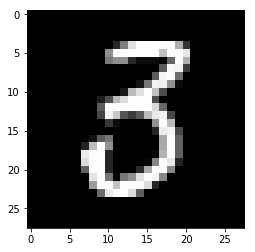

Label: 1


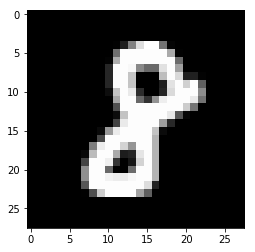

In [32]:
# visualize data and labels
import matplotlib.pyplot as plt
%matplotlib inline

# 3 (label 0)
index = 3000
print("Label:", mnist_train_labels_3_8[index])
plt.imshow(mnist_train_images_3_8[index].reshape(28, 28),cmap='gray')
plt.show()

# 8 (label 1)
index = 8000
print("Label:", mnist_train_labels_3_8[index])
plt.imshow(mnist_train_images_3_8[index].reshape(28, 28),cmap='gray')
plt.show()

In [33]:
    # Naive Random Forest - by flattening the entire image
# Train
clf = RandomForestClassifier()
clf.fit(mnist_train_images_3_8.reshape(-1, 28*28*1), mnist_train_labels_3_8)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
# Naive Random Forest - by flattening the entire image
# Test
mnist_test_preds_3_8 = clf.predict(mnist_test_images_3_8.reshape(-1, 28*28*1))
print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds_3_8)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds_3_8)))

Test Accuracy: 0.983366935483871
Validation Confusion Matrix: 
[[993  17]
 [ 16 958]]


In [42]:
# The Deep Convolution Random Forest class (for binary classification)
class ConvRF(object):
    def __init__(self, kernel_size=5, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_forests = None

    def _convolve_chop(self, images, labels=None, flatten=False):

        batch_size, in_dim, _, num_channels = images.shape

        out_dim = int((in_dim - self.kernel_size) / self.stride) + 1  # calculate output dimensions

        # create matrix to hold the chopped images
        out_images = np.zeros((batch_size, out_dim, out_dim,
                               self.kernel_size, self.kernel_size, num_channels))
        out_labels = None

        curr_y = out_y = 0
        # move kernel vertically across the image
        while curr_y + self.kernel_size <= in_dim:
            curr_x = out_x = 0
            # move kernel horizontally across the image
            while curr_x + self.kernel_size <= in_dim:
                # chop images
                out_images[:, out_x, out_y] = images[:, curr_x:curr_x +
                                                     self.kernel_size, curr_y:curr_y+self.kernel_size, :]
                curr_x += self.stride
                out_x += 1
            curr_y += self.stride
            out_y += 1

        if flatten:
            out_images = out_images.reshape(batch_size, out_dim, out_dim, -1)

        if labels is not None:
            out_labels = np.zeros((batch_size, out_dim, out_dim))
            out_labels[:, ] = labels.reshape(-1, 1, 1)

        return out_images, out_labels

    def convolve_fit(self, images, labels):
        num_channels = images.shape[-1]
        sub_images, sub_labels = self._convolve_chop(images, labels=labels, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        self.kernel_forests = np.zeros((out_dim, out_dim), dtype=np.int).tolist()
        convolved_image = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                self.kernel_forests[i][j] = RandomForestClassifier()
                self.kernel_forests[i][j].fit(sub_images[:, i, j], sub_labels[:, i, j])
                convolved_image[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return convolved_image

    def convolve_predict(self, images):
        if not self.kernel_forests:
            raise Exception("Should fit training data before predicting")

        num_channels = images.shape[-1]
        sub_images, _ = self._convolve_chop(images, flatten=True)

        batch_size, out_dim, _, _ = sub_images.shape
        
        kernel_predictions = np.zeros((images.shape[0], out_dim, out_dim, 1))
        
        for i in range(out_dim):
            for j in range(out_dim):
                kernel_predictions[:, i, j] = self.kernel_forests[i][j].predict_proba(sub_images[:, i, j])[..., 1][..., np.newaxis]
        return kernel_predictions

In [57]:
##########################################################
print("Experiment 1:")
print("No. of ConvRFs: 1")
print("Kernel Size: (3,3); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=3, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(mnist_test_images_3_8), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 1:
No. of ConvRFs: 1
Kernel Size: (3,3); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (13, 13)
Test Accuracy: 0.9611895161290323
Validation Confusion Matrix: 
[[977  33]
 [ 44 930]]


In [58]:
##########################################################
print("Experiment 2:")
print("No. of ConvRFs: 1")
print("Kernel Size: (5,5); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=5, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(mnist_test_images_3_8), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 2:
No. of ConvRFs: 1
Kernel Size: (5,5); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (12, 12)
Test Accuracy: 0.983366935483871
Validation Confusion Matrix: 
[[997  13]
 [ 20 954]]


In [59]:
##########################################################
print("Experiment 3:")
print("No. of ConvRFs: 1")
print("Kernel Size: (10,10); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(mnist_test_images_3_8), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 3:
No. of ConvRFs: 1
Kernel Size: (10,10); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF map output shape: (10, 10)
Test Accuracy: 0.9949596774193549
Validation Confusion Matrix: 
[[1003    7]
 [   3  971]]


In [60]:
##########################################################
print("Experiment 4:")
print("No. of ConvRFs: 1")
print("Kernel Size: (15,15); Stride: 2")
print("Technique: Posteriors (fn: rf.predict_proba())")
## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=15, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print(conv1_map.shape)
print("ConvRF map output shape:", conv1_map.shape[1:-1])

# Full RF
conv1_full_RF = RandomForestClassifier()
conv1_full_RF.fit(conv1_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
mnist_test_preds = conv1_full_RF.predict(conv1_map_test.reshape(len(mnist_test_images_3_8), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 4:
No. of ConvRFs: 1
Kernel Size: (15,15); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
(11982, 7, 7, 1)
ConvRF map output shape: (7, 7)
Test Accuracy: 0.9884072580645161
Validation Confusion Matrix: 
[[999  11]
 [ 12 962]]


In [70]:
##########################################################
print("Experiment 5:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (3,3); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=3, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
mnist_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(mnist_test_images_3_8), -1))


print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 5:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (3,3); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (8, 8)
Test Accuracy: 0.9773185483870968
Validation Confusion Matrix: 
[[1001    9]
 [  36  938]]


In [71]:
##########################################################
print("Experiment 6:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (3,3); Stride: 2") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=3, stride=2)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
mnist_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(mnist_test_images_3_8), -1))


print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 6:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (3,3); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (4, 4)
Test Accuracy: 0.9924395161290323
Validation Confusion Matrix: 
[[1002    8]
 [   7  967]]


In [69]:
##########################################################
print("Experiment 6:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (5,5); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=5, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
mnist_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(mnist_test_images_3_8), -1))


print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 6:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (5,5); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (6, 6)
Test Accuracy: 0.9894153225806451
Validation Confusion Matrix: 
[[1004    6]
 [  15  959]]


In [72]:
##########################################################
print("Experiment 7:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (5,5); Stride: 2") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=5, stride=2)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
mnist_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(mnist_test_images_3_8), -1))


print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 7:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (5,5); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (3, 3)
Test Accuracy: 0.9919354838709677
Validation Confusion Matrix: 
[[1000   10]
 [   6  968]]


In [73]:
##########################################################
print("Experiment 8:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
mnist_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(mnist_test_images_3_8), -1))


print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 8:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (7,7); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (4, 4)
Test Accuracy: 0.9954637096774194
Validation Confusion Matrix: 
[[1005    5]
 [   4  970]]


In [74]:
##########################################################
print("Experiment 9:")
print("No. of ConvRFs: 2")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 2") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=2)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# Full RF
conv2_full_RF = RandomForestClassifier()
conv2_full_RF.fit(conv2_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
mnist_test_preds = conv2_full_RF.predict(conv2_map_test.reshape(len(mnist_test_images_3_8), -1))


print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 9:
No. of ConvRFs: 2
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (7,7); Stride: 2
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (2, 2)
Test Accuracy: 0.9879032258064516
Validation Confusion Matrix: 
[[1002    8]
 [  16  958]]


In [77]:
##########################################################
print("Experiment 10:")
print("No. of ConvRFs: 3")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 1") 
print("ConvRF 3 -> Kernel Size: (2,2); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# ConvRF (layer 3)
conv3 = ConvRF(kernel_size=2, stride=1)
conv3_map = conv3.convolve_fit(conv2_map, mnist_train_labels_3_8)
print("ConvRF 3 map output shape:", conv3_map.shape[1:-1])

# Full RF
conv3_full_RF = RandomForestClassifier()
conv3_full_RF.fit(conv3_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2, ConvRF 3 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
conv3_map_test = conv3.convolve_predict(conv2_map_test)
mnist_test_preds = conv3_full_RF.predict(conv3_map_test.reshape(len(mnist_test_images_3_8), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 10:
No. of ConvRFs: 3
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (7,7); Stride: 1
ConvRF 3 -> Kernel Size: (2,2); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (4, 4)
ConvRF 3 map output shape: (3, 3)
Test Accuracy: 0.9954637096774194
Validation Confusion Matrix: 
[[1005    5]
 [   4  970]]


In [78]:
##########################################################
print("Experiment 11:")
print("No. of ConvRFs: 3")
print("ConvRF 1 -> Kernel Size: (10,10); Stride: 2") 
print("ConvRF 2 -> Kernel Size: (7,7); Stride: 1") 
print("ConvRF 3 -> Kernel Size: (3,3); Stride: 1") 
print("Technique: Posteriors (fn: rf.predict_proba())")

## Train
# ConvRF (layer 1)
conv1 = ConvRF(kernel_size=10, stride=2)
conv1_map = conv1.convolve_fit(mnist_train_images_3_8, mnist_train_labels_3_8)
print("ConvRF 1 map output shape:", conv1_map.shape[1:-1])

# ConvRF (layer 2)
conv2 = ConvRF(kernel_size=7, stride=1)
conv2_map = conv2.convolve_fit(conv1_map, mnist_train_labels_3_8)
print("ConvRF 2 map output shape:", conv2_map.shape[1:-1])

# ConvRF (layer 3)
conv3 = ConvRF(kernel_size=3, stride=1)
conv3_map = conv3.convolve_fit(conv2_map, mnist_train_labels_3_8)
print("ConvRF 3 map output shape:", conv3_map.shape[1:-1])

# Full RF
conv3_full_RF = RandomForestClassifier()
conv3_full_RF.fit(conv3_map.reshape(len(mnist_train_images_3_8), -1), mnist_train_labels_3_8)

## Test (after ConvRF 1, ConvRF 2, ConvRF 3 and Full RF)
conv1_map_test = conv1.convolve_predict(mnist_test_images_3_8)
conv2_map_test = conv2.convolve_predict(conv1_map_test)
conv3_map_test = conv3.convolve_predict(conv2_map_test)
mnist_test_preds = conv3_full_RF.predict(conv3_map_test.reshape(len(mnist_test_images_3_8), -1))

print("Test Accuracy: " + str(accuracy_score(mnist_test_labels_3_8, mnist_test_preds)))
print("Validation Confusion Matrix: \n" + str(confusion_matrix(mnist_test_labels_3_8, mnist_test_preds)))

Experiment 11:
No. of ConvRFs: 3
ConvRF 1 -> Kernel Size: (10,10); Stride: 2
ConvRF 2 -> Kernel Size: (7,7); Stride: 1
ConvRF 3 -> Kernel Size: (3,3); Stride: 1
Technique: Posteriors (fn: rf.predict_proba())
ConvRF 1 map output shape: (10, 10)
ConvRF 2 map output shape: (4, 4)
ConvRF 3 map output shape: (2, 2)
Test Accuracy: 0.9934475806451613
Validation Confusion Matrix: 
[[1004    6]
 [   7  967]]
